In [1]:
"""Modified interpolation script to use a larger source domain"""

import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
#warnings.filterwarnings("ignore")
from dask.distributed import Client
client = Client(n_workers=28)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35785,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:45091,Total threads: 1
Dashboard: /proxy/33775/status,Memory: 35.97 GiB
Nanny: tcp://127.0.0.1:43727,


In [2]:
# target grid (t points)

# - mom6-panan-01
dg = xr.open_dataset("/scratch/g40/wf4500/mom6_topo/shared/ocean_hgrid_panant0025.nc")#.expand_dims(dim={"z_t": 75})
vgrid=xr.open_dataset('/g/data/x77/ahg157/inputs/mom6/panan/vcoord.nc')
z=vgrid.variables['st_ocean']

latout=dg.variables['y'].isel(nxp=slice(0, 1, 1),nyp=slice(-1, None, -1400)).values

#dg['z_t']=  z

dg = (
    dg[["x", "y"]]
    .isel(nxp=slice(0, 28800, 1),nyp=slice(-1, None, -1400))
    .rename(x="lon", y="lat")
)
# source grid (t points)
# - mom6-panan-01
dg01 = xr.open_dataset("/g/data/x77/ahg157/inputs/mom6/panan/ocean_hgrid_0025.nc")
latin=dg01.variables['y'].isel(nxp=slice(0, 1, 1),nyp=slice(-1, None, -600)).values
#dg01['z_t']=  z
dg01 = (
    dg01[["x", "y"]]
    .isel(nxp=slice(0, 14400, 1),nyp=slice(-1, None, -800))
    .rename(x="lon", y="lat")
)
dg

<xarray.Dataset>
Dimensions:  (nyp: 5, nxp: 28800)
Dimensions without coordinates: nyp, nxp
Data variables:
    lon      (nyp, nxp) float64 ...
    lat      (nyp, nxp) float64 ...
Attributes:
    grid_version:          0.2
    code_release_version:  1.0.0
    git_hash:              83acb79
    creationtime:          Tue Feb 14 16:25:35 2023
    hostname:              gadi-login-01.gadi.nci.org.au
    history:               Fri Mar 17 11:18:57 2023: ncks -d nyp,0,6766 -O oc...
    NCO:                   netCDF Operators version 5.1.3 (Homepage = http://...

In [5]:
%%time
regridder = xe.Regridder(
    dg01,
    dg,
    "bilinear",
    periodic=True,
)

CPU times: user 1min 33s, sys: 4.53 s, total: 1min 38s
Wall time: 1min 16s


In [6]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_4x14400_4x28800_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (4, 14400) 
Output grid shape:          (4, 28800) 
Periodic in longitude?      True

In [7]:
#importing and changing input vars

grid005_BF = xr.open_dataset('/g/data/x77/ahg157/inputs/mom6/panan/forcing_obc_shifted.nc')
grid005_BFll = xr.open_dataset('/g/data/x77/ahg157/inputs/mom6/panan/ocean_hgrid_0025.nc')
vgrid=xr.open_dataset('/g/data/x77/ahg157/inputs/mom6/panan/vcoord.nc')


lon=grid005_BFll.variables['x'].values
lon=lon[3380,:]
lat=grid005_BFll.variables['y'].values
lat=lat[3380,0]
z=vgrid.variables['st_ocean'].values


#replacing londitudes indexes for real longitudes from the supergrid
grid005_BF["nx_segment_001"] = ("nx_segment_001", lon)
grid005_BF["ny_segment_001"]= ("ny_segment_001", np.array([lat]))
grid005_BF["nz_segment_001_temp"]= ("nz_segment_001_temp", z)
grid005_BF["nz_segment_001_u"]= ("nz_segment_001_u", z)
grid005_BF["nz_segment_001_v"]= ("nz_segment_001_v", z)
grid005_BF["nz_segment_001_salt"]= ("nz_segment_001_salt", z)
grid005_BF = grid005_BF.rename({'nx_segment_001': 'lon', 'ny_segment_001': 'lat','nz_segment_001_temp': 'z_t',
                                  'nz_segment_001_salt': 'z_s','nz_segment_001_u': 'z_u','nz_segment_001_v': 'z_v'})

In [8]:
%%time
#expanding grid to use xesmf
grid005_BFin = grid005_BF.isel(lon=slice(0, 14400, 1))
grid005_BFin2 = xr.concat([grid005_BFin.isel(lat=0), grid005_BFin.isel(lat=0), grid005_BFin.isel(lat=0)
       , grid005_BFin.isel(lat=0)], dim="lat")                   

CPU times: user 12min 34s, sys: 2min 33s, total: 15min 8s
Wall time: 13min 50s


In [9]:
grid005_BFin2['lat']= ("lat", np.array([-48.02755333,-57.10315453,-64.39592049,-70.73887018]))
grid005_BFin2

<xarray.Dataset>
Dimensions:              (lat: 4, time: 365, z_t: 75, lon: 14400, z_s: 75,
                          z_u: 75, z_v: 75)
Coordinates:
  * lat                  (lat) float64 -48.03 -57.1 -64.4 -70.74
  * lon                  (lon) float64 -280.0 -280.0 -279.9 ... 79.95 79.97
  * z_t                  (z_t) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * z_s                  (z_s) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * z_u                  (z_u) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * z_v                  (z_v) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time                 (time) object 1900-01-01 12:00:00 ... 1900-12-31 12:...
Data variables:
    temp_segment_001     (lat, time, z_t, lon) float64 16.93 16.91 ... 1.857
    ilist_segment_001    (lat, lon) float64 0.0 0.5 1.0 ... 7.199e+03 7.2e+03
    jlist_segment_001    (lat, lon) float64 1.942e+03 1.942e+03 ... 1.942e+03
    dz_temp_segment_001  (lat, time, z_t, lon) float64 1.083 1.083 ... 0.0 0.0
    salt_segment_001     (lat, time, z_s, lon) float64 35.05 35.05 ... 34.79
    dz_salt_segment_001  (lat, time, z_s, lon) float64 1.083 1.083 ... 0.0 0.0
    u_segment_001        (lat, time, z_u, lon) float64 0.1007 ... -0.0009839
    dz_u_segment_001     (lat, time, z_u, lon) float64 1.083 1.083 ... 0.0 0.0
    v_segment_001        (lat, time, z_v, lon) float64 -0.1299 ... -0.006902
    dz_v_segment_001     (lat, time, z_v, lon) float64 1.083 1.083 ... 0.0 0.0
    eta_t_segment_001    (lat, time, lon) float64 0.2136 0.2135 ... 0.211 0.2109
Attributes:
    history:  Thu Mar  4 17:41:04 2021: ncap2 -s temp_segment_001-=273.15 for...
    NCO:      netCDF Operators version 4.9.6 (Homepage = http://nco.sf.net, C...

In [18]:
%%time
#interpolating the temperature
os.chdir('/scratch/g40/wf4500')
def interp_initial(enc):
    # IC in Potential temperature
    time_count = range(0,365)
    zt=range(0,75)
    dd_out2=range(0,0)
    for t in time_count:
        for zi in zt:
            dd = grid005_BFin2[["temp_segment_001"]].isel(time=t,z_t=zi)
            dd_out = regridder(dd)
            #B=dd_out.expand_dims(dim={"z_t": 1,"time":1})
            if zi>0:
                dd_out2=xr.concat([dd_out2,dd_out], dim="z_t") 
            else :
                dd_out2=dd_out
            del dd 
        if t>0:
            dd_out3=xr.concat([dd_out3,dd_out2], dim="time") 
        else:
            dd_out3=dd_out2
    dd_out3=xr.concat([dd_out3,dd_out3.isel(nxp=1)], dim="nxp") 
    dd_out3=dd_out3.rename({'nxp':'nx_segment_001','nyp':'ny_segment_001','z_t':'nz_segment_001_temp'})
    dd_out3=dd_out3.isel(ny_segment_001=-1)
    #dd_out["nxp"] = dd_out["lon"].isel(nyp=0)
    #dd_out["nyp"] = dd_out["lat"].isel(nxp=0)
    #del dd_out["lon"]
    #del dd_out["lat"]
    print(dd_out3)
    dd_out3.to_netcdf("temp_JN.nc", encoding={"temp_segment_001": enc})
enc = {
    "_FillValue": -1e20,
    #"chunksizes": (169, 360),
    # "zlib": True,
    # "shuffle": True,
    # "complevel": 1,
}
# interp_topog(enc)
#enc["chunksizes"] = (1, 75, 169, 360)
interp_initial(enc)


<xarray.Dataset>
Dimensions:              (time: 365, nz_segment_001_temp: 75,
                          nx_segment_001: 28801)
Coordinates:
  * nz_segment_001_temp  (nz_segment_001_temp) float64 0.5413 ... 5.709e+03
  * time                 (time) object 1900-01-01 12:00:00 ... 1900-12-31 12:...
Dimensions without coordinates: nx_segment_001
Data variables:
    temp_segment_001     (time, nz_segment_001_temp, nx_segment_001) float64 ...
Attributes:
    regrid_method:  bilinear
CPU times: user 22min 11s, sys: 19min 59s, total: 42min 11s
Wall time: 40min 59s


In [19]:
%%time
#interpolating the Salinity
os.chdir('/scratch/g40/wf4500')
def interp_initial(enc):
    time_count = range(0,365)
    zt=range(0,75)
    dd_out2=range(0,0)
    for t in time_count:
        for zi in zt:
            dd = grid005_BFin2[["salt_segment_001"]].isel(time=t,z_s=zi)
            dd_out = regridder(dd)
            if zi>0:
                dd_out2=xr.concat([dd_out2,dd_out], dim="z_s") 
            else :
                dd_out2=dd_out
            del dd 
        if t>0:
            dd_out3=xr.concat([dd_out3,dd_out2], dim="time") 
        else:
            dd_out3=dd_out2
    dd_out3=xr.concat([dd_out3,dd_out3.isel(nxp=1)], dim="nxp") 
    dd_out3=dd_out3.rename({'nxp':'nx_segment_001','nyp':'ny_segment_001','z_s':'nz_segment_001_salt'})
    dd_out3=dd_out3.isel(ny_segment_001=-1)
    #dd_out["nxp"] = dd_out["lon"].isel(nyp=0)
    #dd_out["nyp"] = dd_out["lat"].isel(nxp=0)
    #del dd_out["lon"]
    #del dd_out["lat"]
    print(dd_out3)
    dd_out3.to_netcdf("salt_JN.nc", encoding={"salt_segment_001": enc})
enc = {
    "_FillValue": -1e20,
    #"chunksizes": (169, 360),
    # "zlib": True,
    # "shuffle": True,
    # "complevel": 1,
}
# interp_topog(enc)
#enc["chunksizes"] = (1, 75, 169, 360)
interp_initial(enc)

<xarray.Dataset>
Dimensions:              (time: 365, nz_segment_001_salt: 75,
                          nx_segment_001: 28801)
Coordinates:
  * nz_segment_001_salt  (nz_segment_001_salt) float64 0.5413 ... 5.709e+03
  * time                 (time) object 1900-01-01 12:00:00 ... 1900-12-31 12:...
Dimensions without coordinates: nx_segment_001
Data variables:
    salt_segment_001     (time, nz_segment_001_salt, nx_segment_001) float64 ...
Attributes:
    regrid_method:  bilinear
CPU times: user 21min 5s, sys: 18min 33s, total: 39min 38s
Wall time: 38min 24s


In [ ]:
%%time
#interpolating the u
os.chdir('/scratch/g40/wf4500')
def interp_initial(enc):
    time_count = range(0,365)
    zt=range(0,75)
    dd_out2=range(0,0)
    for t in time_count:
        for zi in zt:
            dd = grid005_BFin2[["u_segment_001"]].isel(time=t,z_u=zi)
            dd_out = regridder(dd)
            if zi>0:
                dd_out2=xr.concat([dd_out2,dd_out], dim="z_u") 
            else :
                dd_out2=dd_out
            del dd 
        if t>0:
            dd_out3=xr.concat([dd_out3,dd_out2], dim="time") 
        else:
            dd_out3=dd_out2
    dd_out3=xr.concat([dd_out3,dd_out3.isel(nxp=1)], dim="nxp") 
    dd_out3=dd_out3.rename({'nxp':'nx_segment_001','nyp':'ny_segment_001','z_u':'nz_segment_001_u'})
    dd_out3=dd_out3.isel(ny_segment_001=-1)
    #dd_out["nxp"] = dd_out["lon"].isel(nyp=0)
    #dd_out["nyp"] = dd_out["lat"].isel(nxp=0)
    #del dd_out["lon"]
    #del dd_out["lat"]
    print(dd_out3)
    dd_out3.to_netcdf("u_JN.nc", encoding={"u_segment_001": enc})
enc = {
    "_FillValue": -1e20,
    #"chunksizes": (169, 360),
    # "zlib": True,
    # "shuffle": True,
    # "complevel": 1,
}
# interp_topog(enc)
#enc["chunksizes"] = (1, 75, 169, 360)
interp_initial(enc)

In [ ]:
%%time
#interpolating the v
os.chdir('/scratch/g40/wf4500')
def interp_initial(enc):
    time_count = range(0,365)
    zt=range(0,75)
    dd_out2=range(0,0)
    for t in time_count:
        for zi in zt:
            dd = grid005_BFin2[["v_segment_001"]].isel(time=t,z_v=zi)
            dd_out = regridder(dd)
            if zi>0:
                dd_out2=xr.concat([dd_out2,dd_out], dim="z_v") 
            else :
                dd_out2=dd_out
            del dd 
        if t>0:
            dd_out3=xr.concat([dd_out3,dd_out2], dim="time") 
        else:
            dd_out3=dd_out2
    dd_out3=xr.concat([dd_out3,dd_out3.isel(nxp=1)], dim="nxp") 
    dd_out3=dd_out3.rename({'nxp':'nx_segment_001','nyp':'ny_segment_001','z_v':'nz_segment_001_v'})
    dd_out3=dd_out3.isel(ny_segment_001=-1)
    #dd_out["nxp"] = dd_out["lon"].isel(nyp=0)
    #dd_out["nyp"] = dd_out["lat"].isel(nxp=0)
    #del dd_out["lon"]
    #del dd_out["lat"]
    print(dd_out3)
    dd_out3.to_netcdf("v_JN.nc", encoding={"v_segment_001": enc})
enc = {
    "_FillValue": -1e20,
    #"chunksizes": (169, 360),
    # "zlib": True,
    # "shuffle": True,
    # "complevel": 1,
}
# interp_topog(enc)
#enc["chunksizes"] = (1, 75, 169, 360)
interp_initial(enc)

In [ ]:
%%time
#interpolating the DZ_temperature
os.chdir('/scratch/g40/wf4500')
def interp_initial(enc):
    # IC in Potential temperature
    time_count = range(0,365)
    zt=range(0,75)
    dd_out2=range(0,0)
    for t in time_count:
        for zi in zt:
            dd = grid005_BFin2[["dz_temp_segment_001"]].isel(time=t,z_t=zi)
            dd_out = regridder(dd)
            if zi>0:
                dd_out2=xr.concat([dd_out2,dd_out], dim="z_t") 
            else :
                dd_out2=dd_out
            del dd 
        if t>0:
            dd_out3=xr.concat([dd_out3,dd_out2], dim="time") 
        else:
            dd_out3=dd_out2
    dd_out3=xr.concat([dd_out3,dd_out3.isel(nxp=1)], dim="nxp") 
    dd_out3=dd_out3.rename({'nxp':'nx_segment_001','nyp':'ny_segment_001','z_t':'nz_segment_001_temp'})
    dd_out3=dd_out3.isel(ny_segment_001=-1)
    #dd_out["nxp"] = dd_out["lon"].isel(nyp=0)
    #dd_out["nyp"] = dd_out["lat"].isel(nxp=0)
    #del dd_out["lon"]
    #del dd_out["lat"]
    print(dd_out3)
    dd_out3.to_netcdf("dztemp_JN.nc", encoding={"dz_temp_segment_001": enc})
enc = {
    "_FillValue": -1e20,
    #"chunksizes": (169, 360),
    # "zlib": True,
    # "shuffle": True,
    # "complevel": 1,
}
# interp_topog(enc)
#enc["chunksizes"] = (1, 75, 169, 360)
interp_initial(enc)



In [ ]:
%%time
#interpolating the dz_Salinity
os.chdir('/scratch/g40/wf4500')
def interp_initial(enc):
    time_count = range(0,365)
    zt=range(0,75)
    dd_out2=range(0,0)
    for t in time_count:
        for zi in zt:
            dd = grid005_BFin2[["dz_salt_segment_001"]].isel(time=t,z_s=zi)
            dd_out = regridder(dd)
            if zi>0:
                dd_out2=xr.concat([dd_out2,dd_out], dim="z_s") 
            else :
                dd_out2=dd_out
            del dd 
        if t>0:
            dd_out3=xr.concat([dd_out3,dd_out2], dim="time") 
        else:
            dd_out3=dd_out2
    dd_out3=xr.concat([dd_out3,dd_out3.isel(nxp=1)], dim="nxp") 
    dd_out3=dd_out3.rename({'nxp':'nx_segment_001','nyp':'ny_segment_001','z_s':'nz_segment_001_salt'})
    dd_out3=dd_out3.isel(ny_segment_001=-1)
    #dd_out["nxp"] = dd_out["lon"].isel(nyp=0)
    #dd_out["nyp"] = dd_out["lat"].isel(nxp=0)
    #del dd_out["lon"]
    #del dd_out["lat"]
    print(dd_out3)
    dd_out3.to_netcdf("dzsalt_JN.nc", encoding={"dz_salt_segment_001": enc})
enc = {
    "_FillValue": -1e20,
    #"chunksizes": (169, 360),
    # "zlib": True,
    # "shuffle": True,
    # "complevel": 1,
}
# interp_topog(enc)
#enc["chunksizes"] = (1, 75, 169, 360)
interp_initial(enc)

In [20]:
%%time
#interpolating the dz_u
os.chdir('/scratch/g40/wf4500')
def interp_initial(enc):
    time_count = range(0,365)
    zt=range(0,75)
    dd_out2=range(0,0)
    for t in time_count:
        for zi in zt:
            dd = grid005_BFin2[["dz_u_segment_001"]].isel(time=t,z_u=zi)
            dd_out = regridder(dd)
            if zi>0:
                dd_out2=xr.concat([dd_out2,dd_out], dim="z_u") 
            else :
                dd_out2=dd_out
            del dd 
        if t>0:
            dd_out3=xr.concat([dd_out3,dd_out2], dim="time") 
        else:
            dd_out3=dd_out2
    dd_out3=xr.concat([dd_out3,dd_out3.isel(nxp=1)], dim="nxp") 
    dd_out3=dd_out3.rename({'nxp':'nx_segment_001','nyp':'ny_segment_001','z_u':'nz_segment_001_u'})
    dd_out3=dd_out3.isel(ny_segment_001=-1)
    #dd_out["nxp"] = dd_out["lon"].isel(nyp=0)
    #dd_out["nyp"] = dd_out["lat"].isel(nxp=0)
    #del dd_out["lon"]
    #del dd_out["lat"]
    print(dd_out3)
    dd_out3.to_netcdf("dzu_JN.nc", encoding={"dz_u_segment_001": enc})
enc = {
    "_FillValue": -1e20,
    #"chunksizes": (169, 360),
    # "zlib": True,
    # "shuffle": True,
    # "complevel": 1,
}
# interp_topog(enc)
#enc["chunksizes"] = (1, 75, 169, 360)
interp_initial(enc)

<xarray.Dataset>
Dimensions:           (time: 365, nz_segment_001_u: 75, nx_segment_001: 28801)
Coordinates:
  * nz_segment_001_u  (nz_segment_001_u) float64 0.5413 1.681 ... 5.709e+03
  * time              (time) object 1900-01-01 12:00:00 ... 1900-12-31 12:00:00
Dimensions without coordinates: nx_segment_001
Data variables:
    dz_u_segment_001  (time, nz_segment_001_u, nx_segment_001) float64 1.083 ...
Attributes:
    regrid_method:  bilinear
CPU times: user 21min 20s, sys: 18min 40s, total: 40min 1s
Wall time: 38min 42s


In [21]:
 %%time
#interpolating the dz_v
os.chdir('/scratch/g40/wf4500')
def interp_initial(enc):
    time_count = range(0,365)
    zt=range(0,75)
    dd_out2=range(0,0)
    for t in time_count:
        for zi in zt:
            dd = grid005_BFin2[["dz_v_segment_001"]].isel(time=t,z_v=zi)
            dd_out = regridder(dd)
            if zi>0:
                dd_out2=xr.concat([dd_out2,dd_out], dim="z_v") 
            else :
                dd_out2=dd_out
            del dd 
        if t>0:
            dd_out3=xr.concat([dd_out3,dd_out2], dim="time") 
        else:
            dd_out3=dd_out2
    dd_out3=xr.concat([dd_out3,dd_out3.isel(nxp=1)], dim="nxp") 
    dd_out3=dd_out3.rename({'nxp':'nx_segment_001','nyp':'ny_segment_001','z_v':'nz_segment_001_v'})
    dd_out3=dd_out3.isel(ny_segment_001=-1)
    #dd_out["nxp"] = dd_out["lon"].isel(nyp=0)
    #dd_out["nyp"] = dd_out["lat"].isel(nxp=0)
    #del dd_out["lon"]
    #del dd_out["lat"]
    print(dd_out3)
    dd_out3.to_netcdf("dzv_JN.nc", encoding={"dz_v_segment_001": enc})
enc = {
    "_FillValue": -1e20,
    #"chunksizes": (169, 360),
    # "zlib": True,
    # "shuffle": True,
    # "complevel": 1,
}
# interp_topog(enc)
#enc["chunksizes"] = (1, 75, 169, 360)
interp_initial(enc)

<xarray.Dataset>
Dimensions:           (time: 365, nz_segment_001_v: 75, nx_segment_001: 28801)
Coordinates:
  * nz_segment_001_v  (nz_segment_001_v) float64 0.5413 1.681 ... 5.709e+03
  * time              (time) object 1900-01-01 12:00:00 ... 1900-12-31 12:00:00
Dimensions without coordinates: nx_segment_001
Data variables:
    dz_v_segment_001  (time, nz_segment_001_v, nx_segment_001) float64 1.083 ...
Attributes:
    regrid_method:  bilinear
CPU times: user 21min 22s, sys: 18min 46s, total: 40min 8s
Wall time: 39min 27s


In [ ]:
%%time
#interpolating the eta_t
os.chdir('/scratch/g40/wf4500')
def interp_initial(enc):
    # IC in Potential temperature
    time_count = range(0,365)
    zt=range(0,75)
    dd_out2=range(0,0)
    for t in time_count:
        dd = grid005_BFin2[["eta_t_segment_001"]].isel(time=t)
        dd_out = regridder(dd)
        if t>0:
            dd_out2=xr.concat([dd_out2,dd_out], dim="time") 
        else:
            dd_out2=dd_out
        del dd 
    dd_out2=xr.concat([dd_out2,dd_out2.isel(nxp=1)], dim="nxp") 
    dd_out2=dd_out2.rename({'nxp':'nx_segment_001','nyp':'ny_segment_001'})
    dd_out2=dd_out2.isel(ny_segment_001=-1)
    #dd_out["nxp"] = dd_out["lon"].isel(nyp=0)
    #dd_out["nyp"] = dd_out["lat"].isel(nxp=0)
    #del dd_out["lon"]
    #del dd_out["lat"]
    dd_out2.to_netcdf("eta_JN.nc", encoding={"eta_t_segment_001": enc})
enc = {
    "_FillValue": -1e20,
    #"chunksizes": (169, 360),
    # "zlib": True,
    # "shuffle": True,
    # "complevel": 1,
}
# interp_topog(enc)
#enc["chunksizes"] = (1, 75, 169, 360)
interp_initial(enc)

In [ ]:
#changing all xan y coordinates (nxp and nyp) back to intexes

In [42]:
#changing all xan y coordinates (nxp and nyp) back to intexes
#for temperature
temp_JN2 = xr.open_dataset('/scratch/g40/wf4500/temp_JN.nc')
zind=range(0,75)
temp_JN2['nz_segment_001_temp']=("nz_segment_001_temp", zind)
temp_JN2.to_netcdf("/scratch/g40/wf4500/temp_JN2.nc")

#for salinity
salt_JN2 = xr.open_dataset('/scratch/g40/wf4500/salt_JN.nc')
salt_JN2['nz_segment_001_salt']=("nz_segment_001_salt", zind)
salt_JN2.to_netcdf("/scratch/g40/wf4500/salt_JN2.nc")


#for dzu
dzu_JN2 = xr.open_dataset('/scratch/g40/wf4500/dzu_JN.nc')
dzu_JN2['nz_segment_001_u']=("nz_segment_001_u", zind)
dzu_JN2.to_netcdf("/scratch/g40/wf4500/dzu_JN2.nc")



#for dzv
dzv_JN2 = xr.open_dataset('/scratch/g40/wf4500/dzv_JN.nc')
dzv_JN2['nz_segment_001_v']=("nz_segment_001_v", zind)
dzv_JN2.to_netcdf("/scratch/g40/wf4500/dzv_JN2.nc")


#for v
v_JN2 = xr.open_dataset('/scratch/g40/wf4500/v_JN.nc')
v_JN2['nz_segment_001_v']=("nz_segment_001_v", zind)
v_JN2.to_netcdf("/scratch/g40/wf4500/v_JN2.nc")


#for u
u_JN2 = xr.open_dataset('/scratch/g40/wf4500/u_JN.nc')
u_JN2['nz_segment_001_u']=("nz_segment_001_u", zind)
u_JN2.to_netcdf("/scratch/g40/wf4500/u_JN2.nc")


#for dz_temp
dzt_JN2 = xr.open_dataset('/scratch/g40/wf4500/dztemp_JN.nc')
dzt_JN2['nz_segment_001_temp']=("nz_segment_001_temp", zind)
dzt_JN2.to_netcdf("/scratch/g40/wf4500/dztemp_JN2.nc")



#for dz_salt
dzs_JN2 = xr.open_dataset('/scratch/g40/wf4500/dzsalt_JN.nc')
dzs_JN2['nz_segment_001_salt']=("nz_segment_001_salt", zind)
dzs_JN2.to_netcdf("/scratch/g40/wf4500/dzsalt_JN2.nc")


<xarray.Dataset>
Dimensions:              (time: 365, nz_segment_001_salt: 75,
                          nx_segment_001: 28801)
Coordinates:
  * nz_segment_001_salt  (nz_segment_001_salt) int64 0 1 2 3 4 ... 71 72 73 74
  * time                 (time) object 1900-01-01 12:00:00 ... 1900-12-31 12:...
Dimensions without coordinates: nx_segment_001
Data variables:
    dz_salt_segment_001  (time, nz_segment_001_salt, nx_segment_001) float64 ...
Attributes:
    regrid_method:  bilinear

CPU times: user 33.9 s, sys: 20 s, total: 53.9 s
Wall time: 1min 36s


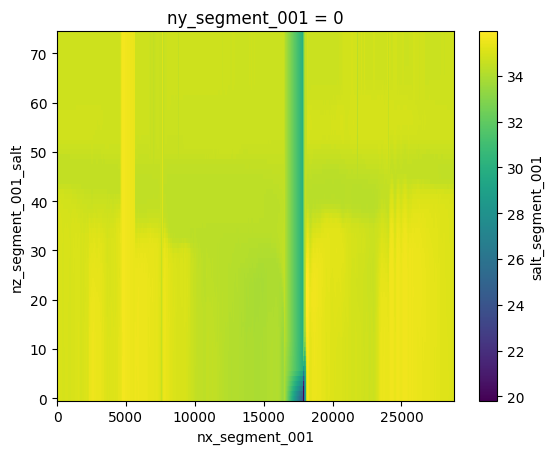

In [6]:
%%time
os.chdir('/scratch/g40/wf4500')
#Before running this cell I copied eta_t_JN.nc to eta_t_JN2.nc
#This has to be done oterwise eta_t wont be in teh BF file
dsf = xr.open_mfdataset('/scratch/g40/wf4500/*_JN2.nc')

grid005_BF = xr.open_dataset('/g/data/x77/ahg157/inputs/mom6/panan/forcing_obc_shifted.nc')

ny=grid005_BF["ny_segment_001"]
nx=dsf["nx_segment_001"]
grid40th=dsf
#grid40th=grid40th.expand_dims({"ny_segment_001": 1})
grid40th=grid40th.assign_coords({"ny_segment_001": ny})
grid40th=grid40th.assign_coords({"nx_segment_001": nx})
grid40th["temp_segment_001"] = grid40th["temp_segment_001"].expand_dims("ny_segment_001", axis=2)
grid40th["salt_segment_001"] = grid40th["salt_segment_001"].expand_dims("ny_segment_001", axis=2)
grid40th["u_segment_001"] = grid40th["u_segment_001"].expand_dims("ny_segment_001", axis=2)
grid40th["v_segment_001"] = grid40th["v_segment_001"].expand_dims("ny_segment_001", axis=2)
grid40th["eta_t_segment_001"] = grid40th["eta_t_segment_001"].expand_dims("ny_segment_001", axis=1)
grid40th["dz_temp_segment_001"] = grid40th["dz_temp_segment_001"].expand_dims("ny_segment_001", axis=2)
grid40th["dz_salt_segment_001"] = grid40th["dz_salt_segment_001"].expand_dims("ny_segment_001", axis=2)
grid40th["dz_u_segment_001"] = grid40th["dz_u_segment_001"].expand_dims("ny_segment_001", axis=2)
grid40th["dz_v_segment_001"] = grid40th["dz_v_segment_001"].expand_dims("ny_segment_001", axis=2)

grid40th["salt_segment_001"].mean(dim='time').plot()



In [124]:
#I need to also add ilist and jlist to the data. 
  #This is a vector that should increase from 0, by 0.5, until listmax=(n-1)/2, where n is the length of the
  #dimension (i or j) in the supergrid. 
  #For example,  for  panant 1/40th, longitude (i) has n=28801. so ilist should have listmax=14400, and be [0:0.5:14400]
ilist=np.arange(0,14400.5,0.5)

#In turn, jlist seem to be a matrix full of equal values (1942). 
#Ill make the same for the 1/40th but check wih everyone if this is correct.
jlistcons=grid005_BF["jlist_segment_001"].min()
jlist=np.multiply(np.ones([28801,1]),1942.).T


grid40th["ilist_segment_001"]=grid005_BF["ilist_segment_001"]
grid40th['ilist_segment_001'][:]=ilist
grid40th["jlist_segment_001"]=grid005_BF["jlist_segment_001"]
grid40th['jlist_segment_001'][:]=np.array(jlist)

grid40th

<xarray.Dataset>
Dimensions:              (nz_segment_001_salt: 75, time: 365,
                          nz_segment_001_temp: 75, nz_segment_001_u: 75,
                          nz_segment_001_v: 75, ny_segment_001: 1,
                          nx_segment_001: 28801)
Coordinates:
  * nz_segment_001_salt  (nz_segment_001_salt) int64 0 1 2 3 4 ... 71 72 73 74
  * time                 (time) object 1900-01-01 12:00:00 ... 1900-12-31 12:...
  * nz_segment_001_temp  (nz_segment_001_temp) int64 0 1 2 3 4 ... 71 72 73 74
  * nz_segment_001_u     (nz_segment_001_u) int64 0 1 2 3 4 5 ... 70 71 72 73 74
  * nz_segment_001_v     (nz_segment_001_v) int64 0 1 2 3 4 5 ... 70 71 72 73 74
  * ny_segment_001       (ny_segment_001) int32 0
  * nx_segment_001       (nx_segment_001) int64 0 1 2 3 ... 28798 28799 28800
Data variables:
    dz_salt_segment_001  (time, nz_segment_001_salt, ny_segment_001, nx_segment_001) float64 dask.array<chunksize=(365, 75, 1, 28801), meta=np.ndarray>
    dz_temp_segment_001  (time, nz_segment_001_temp, ny_segment_001, nx_segment_001) float64 dask.array<chunksize=(365, 75, 1, 28801), meta=np.ndarray>
    dz_u_segment_001     (time, nz_segment_001_u, ny_segment_001, nx_segment_001) float64 dask.array<chunksize=(365, 75, 1, 28801), meta=np.ndarray>
    dz_v_segment_001     (time, nz_segment_001_v, ny_segment_001, nx_segment_001) float64 dask.array<chunksize=(365, 75, 1, 28801), meta=np.ndarray>
    eta_t_segment_001    (time, ny_segment_001, nx_segment_001) float64 dask.array<chunksize=(365, 1, 28801), meta=np.ndarray>
    salt_segment_001     (time, nz_segment_001_salt, ny_segment_001, nx_segment_001) float64 dask.array<chunksize=(365, 75, 1, 28801), meta=np.ndarray>
    temp_segment_001     (time, nz_segment_001_temp, ny_segment_001, nx_segment_001) float64 dask.array<chunksize=(365, 75, 1, 28801), meta=np.ndarray>
    u_segment_001        (time, nz_segment_001_u, ny_segment_001, nx_segment_001) float64 dask.array<chunksize=(365, 75, 1, 28801), meta=np.ndarray>
    v_segment_001        (time, nz_segment_001_v, ny_segment_001, nx_segment_001) float64 dask.array<chunksize=(365, 75, 1, 28801), meta=np.ndarray>
    ilist_segment_001    (ny_segment_001, nx_segment_001) float64 0.0 ... 1.4...
    jlist_segment_001    (ny_segment_001, nx_segment_001) float64 1.942e+03 ....
Attributes:
    regrid_method:  bilinear

In [126]:
#finally saving netcdf
grid40th.to_netcdf("/g/data/x77/wf4500/forcing_final_140th.nc")

In [127]:
grid40th

<xarray.Dataset>
Dimensions:              (nz_segment_001_salt: 75, time: 365,
                          nz_segment_001_temp: 75, nz_segment_001_u: 75,
                          nz_segment_001_v: 75, ny_segment_001: 1,
                          nx_segment_001: 28801)
Coordinates:
  * nz_segment_001_salt  (nz_segment_001_salt) int64 0 1 2 3 4 ... 71 72 73 74
  * time                 (time) object 1900-01-01 12:00:00 ... 1900-12-31 12:...
  * nz_segment_001_temp  (nz_segment_001_temp) int64 0 1 2 3 4 ... 71 72 73 74
  * nz_segment_001_u     (nz_segment_001_u) int64 0 1 2 3 4 5 ... 70 71 72 73 74
  * nz_segment_001_v     (nz_segment_001_v) int64 0 1 2 3 4 5 ... 70 71 72 73 74
  * ny_segment_001       (ny_segment_001) int32 0
  * nx_segment_001       (nx_segment_001) int64 0 1 2 3 ... 28798 28799 28800
Data variables:
    dz_salt_segment_001  (time, nz_segment_001_salt, ny_segment_001, nx_segment_001) float64 dask.array<chunksize=(365, 75, 1, 28801), meta=np.ndarray>
    dz_temp_segment_001  (time, nz_segment_001_temp, ny_segment_001, nx_segment_001) float64 dask.array<chunksize=(365, 75, 1, 28801), meta=np.ndarray>
    dz_u_segment_001     (time, nz_segment_001_u, ny_segment_001, nx_segment_001) float64 dask.array<chunksize=(365, 75, 1, 28801), meta=np.ndarray>
    dz_v_segment_001     (time, nz_segment_001_v, ny_segment_001, nx_segment_001) float64 dask.array<chunksize=(365, 75, 1, 28801), meta=np.ndarray>
    eta_t_segment_001    (time, ny_segment_001, nx_segment_001) float64 dask.array<chunksize=(365, 1, 28801), meta=np.ndarray>
    salt_segment_001     (time, nz_segment_001_salt, ny_segment_001, nx_segment_001) float64 dask.array<chunksize=(365, 75, 1, 28801), meta=np.ndarray>
    temp_segment_001     (time, nz_segment_001_temp, ny_segment_001, nx_segment_001) float64 dask.array<chunksize=(365, 75, 1, 28801), meta=np.ndarray>
    u_segment_001        (time, nz_segment_001_u, ny_segment_001, nx_segment_001) float64 dask.array<chunksize=(365, 75, 1, 28801), meta=np.ndarray>
    v_segment_001        (time, nz_segment_001_v, ny_segment_001, nx_segment_001) float64 dask.array<chunksize=(365, 75, 1, 28801), meta=np.ndarray>
    ilist_segment_001    (ny_segment_001, nx_segment_001) float64 0.0 ... 1.4...
    jlist_segment_001    (ny_segment_001, nx_segment_001) float64 1.942e+03 ....
Attributes:
    regrid_method:  bilinear